***
$$\mathbf{\text{Simulation/Experimental Output Processing and ML-MF Correction}}$$<br>
$$\mathbf{\text{Author: Kenneth Kusima}}$$<br>
$\mathbf{\text{Date: 03/01}}$<br>

***
$\mathbf{\text{Model being explored: Simple 4-step CO Oxidation}}:$<br>

${\text{Corresponding Micro Kinetic Model}}:$<br>
***
$$\require{mhchem}$$       
---
Overall Reaction: 
$$ CO + \frac{1}{2} O_2 {\stackrel{\tiny{\textrm{Pt/Pd}}}{\rightleftharpoons}} CO_2 $$
---
Note Reations in the Reaction Mechanism may be reversible or irreversible

Reaction 1:&emsp;Adsorption of CO

$$ CO + * \rightleftharpoons CO^{*} $$

Reaction 2:&emsp;Adsorption of $O_2$

$$ O_2 + * \rightleftharpoons {O_2}^{*} $$

Reaction 3:&emsp;Dissociation of ${O_2}^*$ 

$$ {O_2}^* + * \rightleftharpoons 2{O}^* $$

Reaction 4:&emsp;Surface Reaction of $CO$ and $O_2$  

$$ {CO}^{*} + {O}^{*} \rightleftharpoons CO_2 + 2* $$

In [1]:
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil

***

<a id="top"></a><br>
 # Table of Contents  
1. [Loading in the labeled simulation folders](#1)   
    1. [Checking all simulations were completed as expected](#1.1)
1. [Developing ML Training Dataset for rate correction](#2) 
    1. [Generating Experimental Data Dictionary](#2.1) 
    1. [Generating MF-MKM Data Dictionary](#2.2)     
    1. [Creating Features](#2.3)      
        C1. [Log ratio](#2.3.1)     
        C2. [Percent Difference](#2.3.2)    
        
    1. [Creating Input/Feature Tensor](#2.4)
    1. [Extracting Full X (Feature) and Y(Target) datasets](#2.5)
    1. [Performing Train/Test X and Y Split datasets](#2.6)
1. [Modelling](#3)
1. [Describing Possible Machine Learning Model Algorithms](#4)
1. [Selecting and Training the Model](#5)
1. [Importing External/Experimental Data to be used in the model](#6)
    1. [Generating corresponding MF-MKModel](#6.1) 
    1. [Predicting Machine-Learned Mean-Field Corrections](#6.2)
    1. [ML Correction to MF-MKModel](#6.3)
    1. [Evaluating the ML model prediction](#6.4)
    1. [Plotting results](#6.5)
    
1. [Exploring and Evaluating possible ML options](#7)

***
<a id="1"></a> 
## 1. Loading in the labeled simulation folders
<a href="#top">Back to top</a>

In [2]:
os.getcwd()

'/Users/klkusima/Desktop/RASH Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/Input data_KMC/KMC_output_varied_coverage'

In [3]:
%%time
Sim_folder_names = []
i = 0
for file in glob.glob("Sim_*"):
    Sim_folder_names.append(file)
    i+=1
print('Number of simulations:',i)
print(Sim_folder_names)
#os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

Number of simulations: 55
['Sim_A_0_B_77', 'Sim_A_44_B_55', 'Sim_A_55_B_22', 'Sim_A_22_B_77', 'Sim_A_88_B_11', 'Sim_A_22_B_22', 'Sim_A_33_B_0', 'Sim_A_33_B_55', 'Sim_A_0_B_22', 'Sim_A_22_B_0', 'Sim_A_66_B_11', 'Sim_A_11_B_44', 'Sim_A_11_B_88', 'Sim_A_11_B_11', 'Sim_A_0_B_100', 'Sim_A_77_B_11', 'Sim_A_11_B_33', 'Sim_A_11_B_66', 'Sim_A_66_B_33', 'Sim_A_44_B_0', 'Sim_A_44_B_22', 'Sim_A_55_B_0', 'Sim_A_100_B_0', 'Sim_A_22_B_55', 'Sim_A_0_B_55', 'Sim_A_33_B_22', 'Sim_A_33_B_66', 'Sim_A_0_B_11', 'Sim_A_44_B_33', 'Sim_A_55_B_44', 'Sim_A_66_B_0', 'Sim_A_0_B_0', 'Sim_A_22_B_11', 'Sim_A_55_B_11', 'Sim_A_22_B_44', 'Sim_A_33_B_33', 'Sim_A_0_B_88', 'Sim_A_0_B_44', 'Sim_A_11_B_22', 'Sim_A_66_B_22', 'Sim_A_11_B_77', 'Sim_A_77_B_0', 'Sim_A_88_B_0', 'Sim_A_11_B_0', 'Sim_A_11_B_55', 'Sim_A_77_B_22', 'Sim_A_44_B_44', 'Sim_A_0_B_66', 'Sim_A_33_B_11', 'Sim_A_22_B_66', 'Sim_A_55_B_33', 'Sim_A_22_B_33', 'Sim_A_44_B_11', 'Sim_A_0_B_33', 'Sim_A_33_B_44']
CPU times: user 860 µs, sys: 705 µs, total: 1.56 ms
Wall

In [4]:
set_init_coverages = np.empty([len(Sim_folder_names),4])
#Remember: A='CO*'; B='O*'
#Reading A and B initial coverages from the KMC simulation input coverage files
c = 0 #counter
for s in Sim_folder_names:
    set_coverages = []
    for i in np.arange(len(s)):
        if i<(len(s)-2) and s[i].isdigit() and (s[i+1]).isdigit() and (s[i+2]).isdigit():
            cov_triple = int(s[i:i+3])
            set_coverages.append(cov_triple)
            
        elif i<(len(s)-1) and s[i].isdigit() and (s[i+1]).isdigit()and not((s[i-1]).isdigit()):
            cov_double = int(s[i:i+2])
            set_coverages.append(cov_double)
            
#             print(cov_double)
        elif s[i].isdigit() and not((s[i-1]).isdigit()) and not((s[i-2]).isdigit()):
            cov_single = int(s[i])
            set_coverages.append(cov_single)
                                #A_CO*_covg,     B_O*_covg,     O2*_covg,*_covg
    set_init_coverages[c,:] = [set_coverages[0],set_coverages[1],0,100-sum(set_coverages)]
    c+=1 #counter

In [5]:
os.getcwd()

'/Users/klkusima/Desktop/RASH Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/Input data_KMC/KMC_output_varied_coverage'

In [6]:
#Checking to see match
## Copying all the other input files into the different simulation folders
# Extracting initial coverages
#Remember: A='CO*'; B='O*'
Exp_init_coverages = np.empty([len(Sim_folder_names),4])
c = 0 #counter
for s in Sim_folder_names:
    os.chdir(s)
    file=open('specnum_output.txt','r').readlines() #Reading in the relevant file
    b=[]
    for i in np.arange(len(file)): 
        b.append(file[i].split())                   #Dividing the rows into columns
    o = pd.DataFrame(data=b)                        #Final output

#     print(o)
    #Extracting Number of Sites from the general_output file:
    inp=open('general_output.txt','r').readlines()
    for i in np.arange(len(inp)): 
        if 'Total number of lattice sites:' in inp[i]:
            val = i  #Line in text file where sentence is present

    sites = int(inp[val][35:])
    
    #Finding number of surface species
    headings = (o.iloc[0,:])
    n_ss = sum('*' in h for h in headings) #Number of surface species
    
    #Finding number of gas species
    n_gs = len(headings)-5-n_ss
    
    #Adding column to calculate number of empty sites
    n_c=(len(o.iloc[0,:])) #number of current columns
    o[n_c]=" "           #Creating new empty column 
    o.iloc[0,n_c]="*"    #Labelling the new empty column 

    st = 0 #Initializing empty site coverage vector


    for i in range(len(o.iloc[1:])):
        if n_ss==0:
            site = sites
        else:
            for j in range(n_ss):
                st = st + float(o.iloc[i+1,5+j]) #Calculating no. of empty sites #Asuming empty sites are first to be reportes (i.e @5)
            site = sites - st
            st = 0
        o.iloc[i+1,n_c] = site
    
    Sspecies = []
    for i in range(n_ss):
        Sspecies.append(5+i) 
    Sspecies.append(len(o.iloc[1,:])-1)#Including empty sites

    #Calculating itme:
    Gtime = o[2][1:].astype(float) 
    #Calculating coverages:
    Scoverages = np.empty([len(o.iloc[:,1])-1,len(Sspecies)])
    for i in range(len(Scoverages[1,:])):
        Scoverages[:,i] = o[Sspecies[i]][1:].astype(float)/sites
        
    int_covg = [Scoverages[0,1],Scoverages[0,0],Scoverages[0,2],Scoverages[0,3]]
                        #A_CO*_covg,     B_O*_covg,     O2*_covg,*_covg
    Exp_init_coverages[c,:]= [Scoverages[0,1],Scoverages[0,0],Scoverages[0,2],Scoverages[0,3]]
    
    c+=1
    
    os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

<a id="1.1"></a> 
## 1.1 Checking all simulations were completed as expected
<a href="#top">Back to top</a>

In [7]:
if np.shape(set_init_coverages) != np.shape(Exp_init_coverages):
    raise Exception('Not all simulations have been completed successfully')
    
for i in np.arange(np.shape(set_init_coverages)[0]):
    for j in np.arange(np.shape(set_init_coverages)[1]):
        norm_val = set_init_coverages[i,j]
        exp_val = round(Exp_init_coverages[i,j])
        if not( norm_val + 1 > exp_val) and not(norm_val - 1 < exp_val): #i.e if not within range
            raise Exception('Initial coverages used in the simulation are not the same as it was set')
            
        if (i==(np.shape(set_init_coverages)[0] - 1) and j==(np.shape(set_init_coverages)[1] - 1)):
            print('SIMULATIONS MATCH AS EXPECTED')

SIMULATIONS MATCH AS EXPECTED


***
<a id="2"></a> 
## 2. Developing ML Training Dataset for rate correction
<a href="#top">Back to top</a>

## Dictionary formats:

***
<a id="2.1"></a> 
## 2.A  Generating Experimental Data Dictionary
<a href="#top">Back to top</a>

In [8]:
#os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

In [9]:
%%time
## Copying all the other input files into the different simulation folders
# Extracting initial coverages
#Remember: A='CO*'; B='O*'
n = len(Sim_folder_names)
Covg = np.zeros((n,500,4)) #CO*, O*, O2*, *
Rates = np.zeros((n,500,3)) #CO, O2, CO2
KMC_time_Array = np.zeros((n,500))
init_coverages = np.empty([n,4])
c = 0 #counter for number of simulation (folders)

for s in Sim_folder_names:
    os.chdir(s)
    file=open('specnum_output.txt','r').readlines() #Reading in the relevant file
    b=[]
    for i in np.arange(len(file)): 
        b.append(file[i].split())                   #Dividing the rows into columns
    o = pd.DataFrame(data=b)                        #Final output

#     print(o)
    #Extracting Number of Sites from the general_output file:
    inp=open('general_output.txt','r').readlines()
    for i in np.arange(len(inp)): 
        if 'Total number of lattice sites:' in inp[i]:
            val = i  #Line in text file where sentence is present

    sites = int(inp[val][34:])
    
    #Finding number of surface species
    headings = (o.iloc[0,:])
    n_ss = sum('*' in h for h in headings) #Number of surface species
    
    #Finding number of gas species
    n_gs = len(headings)-5-n_ss
    
    #Adding column to calculate number of empty sites
    n_c=(len(o.iloc[0,:])) #number of current columns
    o[n_c]=" "           #Creating new empty column 
    o.iloc[0,n_c]="*"    #Labelling the new empty column 

    st = 0 #Initializing empty site coverage vector


    for i in range(len(o.iloc[1:])):
        if n_ss==0:
            site = sites
        else:
            for j in range(n_ss):
                st = st + float(o.iloc[i+1,5+j]) #Calculating no. of empty sites #Asuming empty sites are first to be reportes (i.e @5)
            site = sites - st
            st = 0
        o.iloc[i+1,n_c] = site
    
    Sspecies = []
    for i in range(n_ss):
        Sspecies.append(5+i) 
    Sspecies.append(len(o.iloc[1,:])-1)#Including empty sites

    #Calculating itme:
    Gtime = o[2][1:].astype(float) 
    #Calculating coverages:
    Scoverages = np.empty([len(o.iloc[:,1])-1,len(Sspecies)])
    for i in range(len(Scoverages[1,:])):
        Scoverages[:,i] = o[Sspecies[i]][1:].astype(float)/sites
        
    Gspecies = []
    for i in range(n_gs):
        Gspecies.append(5+n_ss+i) 
        
    #Extracting the number of gas species molecules:    
    Gnmol = np.empty([len(o.iloc[:,1])-1,len(Gspecies)])
    for i in range(len(Gnmol[1,:])):
        Gnmol[:,i] = o[Gspecies[i]][1:].astype(float)
    
    ### Calculating the instantaneous rates of profuction (i.e grad/sites)
    TOF_GS = np.empty([len(o.iloc[:,1])-1,len(Gspecies)]) #initializing an array of instantaneous TOFs for gaseous species
    # grads = np.empty([len(o.iloc[:,1])-1,1])
    for i in np.arange(len(Gspecies)):
        grads = np.gradient(Gnmol[:,i],Gtime,edge_order=2)
        TOF_GS[:,i] = grads/sites
    
    STOF_O2 = pd.Series(TOF_GS[:,0])
    STOF_CO = pd.Series(TOF_GS[:,1])
    STOF_CO2 = pd.Series(TOF_GS[:,2])
    Rates_p = pd.DataFrame(list(zip(STOF_CO, STOF_O2, STOF_CO2)),
                    columns =['R_CO', 'R_O2', 'R_CO2'])

    int_covg = [Scoverages[0,1],Scoverages[0,0],Scoverages[0,2],Scoverages[0,3]]
                        #A_CO*_covg,     B_O*_covg,     O2*_covg,         *_covg
    init_coverages[c,:]= [Scoverages[0,1],Scoverages[0,0],Scoverages[0,2],Scoverages[0,3]] #Initial coverages
    
    KMC_time_Array[c,:]= Gtime #Time matrix
     
    Covg[c,:,:] = Scoverages #Coverage profile tensor
    
    Rates[c,:,:] = Rates_p
    
    c+=1
        
    os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

#https://stackoverflow.com/questions/49881570/python-dictionaries-appending-arrays-to-a-dictionary-for-a-specific-key
data_KMC_dict = {'init_covg': init_coverages, 'sim_time': KMC_time_Array, 'covg_prof': Covg, 'iRates': Rates}

CPU times: user 3.52 s, sys: 29.2 ms, total: 3.55 s
Wall time: 3.58 s


***
<a id="2.2"></a> 
## 2.B  Generating MF-MKModel Data Dictionary
<a href="#top">Back to top</a>

In [10]:
%%time
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.set_rxnconditions(Pr=[(1.0e-4*1.0e-5), (1.0e-4*0.1), 0])
MKM_init_coverages = np.empty([len(Sim_folder_names),4])

def MKM_Model_k_opt_curveft(x,*fit_params):
    MKM_Covg = np.zeros((n,500,4)) #CO*, O*, O2*, *
    MKM_Rates = np.zeros((n,500,3)) #CO, O2, CO2
    time_MKM_Array = np.zeros((n,500))

    MKM.k = np.array(fit_params)
    
    #Remember: A='CO*'; B='O*'
    #Reading A and B initial coverages from the KMC simulation input coverage file names!
    c = 0 #counter
    for s in Sim_folder_names:
        set_coverages = []
        for i in np.arange(len(s)):
            if i<(len(s)-2) and s[i].isdigit() and (s[i+1]).isdigit() and (s[i+2]).isdigit():
                cov_triple = int(s[i:i+3])
                set_coverages.append(cov_triple)

            elif i<(len(s)-1) and s[i].isdigit() and (s[i+1]).isdigit()and not((s[i-1]).isdigit()):
                cov_double = int(s[i:i+2])
                set_coverages.append(cov_double)

            elif s[i].isdigit() and not((s[i-1]).isdigit()) and not((s[i-2]).isdigit()):
                cov_single = int(s[i])
                set_coverages.append(cov_single)
                                    #A_CO*_covg,     B_O*_covg,     O2*_covg,*_covg
        init_covgs = [set_coverages[0]/100,set_coverages[1]/100,0,(100-sum(set_coverages))/100]

        MKM.set_initial_coverages(init=init_covgs)
        MKM_init_coverages[c,:] = [float(i) for i in init_covgs]

        sola,solta = MKM.solve_coverage(Tf_eval=data_KMC_dict['sim_time'][0],plot=False)
        time_MKM_Array[c,:]= solta #Time matrix
        MKM_Covg[c,:,:] = sola #Coverage profile tensor

        solb,soltb = MKM.solve_rate_production(Tf_eval=data_KMC_dict['sim_time'][0],plot=False)
        MKM_Rates[c,:,:] = solb[:,0:3]

        print(c)
        c+=1 #counter

    data_MKM_dict = {'init_covg': MKM_init_coverages, 'sim_time': time_MKM_Array, 'covg_prof': MKM_Covg, 'iRates': MKM_Rates}
    return np.reshape(data_MKM_dict['covg_prof'],data_MKM_dict['covg_prof'].size)

Mass is conserved. 

CPU times: user 322 ms, sys: 79.1 ms, total: 402 ms
Wall time: 652 ms


In [11]:
MKM.Tolerances(dplaces = 50, reltols = 1e-3, abstols=1e-11)

(50, 0.001, 1e-11)

***
<a id="2.3.1"></a> 
## 2.B.1 Optimizing Rate Constant:
<a href="#top">Back to top</a>

In [12]:
%%time
x_values = data_KMC_dict['init_covg'] #Normalized Input Time variables (Independent Variable) (eg. KMC Time)
y_values = np.reshape(data_KMC_dict['covg_prof'],data_KMC_dict['covg_prof'].size) #Normalized Input Dependent variable(s) (eg. KMC coverages)

initial_vals = np.array(MKM.k)

normox = None #np.where(y_values<1e-3,1000,y_values)
params, params_covariance = optimize.curve_fit(MKM_Model_k_opt_curveft, x_values, y_values, sigma = normox
                                            ,method = 'trf', bounds=(0,1e10), maxfev=1000, xtol=1e-5, ftol=1e-5, gtol=1e-5
                                            ,p0=initial_vals)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26

In [13]:
params 

array([6.71079553e-02, 2.22287470e-02, 7.66954552e+02, 4.02390239e+05,
       2.59915381e+05, 1.16978453e-01, 1.29424213e-02, 5.00000000e+02])

In [43]:
print('conf:', np.sqrt(np.diag(params_covariance)))

conf: [5.35151180e-02 2.83541911e-04 8.53125500e-01 4.78132473e+05
 3.09171121e+05 2.82392614e-03 1.84983073e-03 0.00000000e+00]


***
<a id="2.3.2"></a> 
## 2.B.2 Generating NEW MF-MKModel Data Dictionary:
<a href="#top">Back to top</a>

In [14]:
%%time
fitted_k = params
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.set_rxnconditions(Pr=[(1.0e-4*1.0e-5), (1.0e-4*0.1), 0])
MKM_init_coverages = np.empty([len(Sim_folder_names),4])

data_points = len(data_KMC_dict['sim_time'][0])
no_surf_species = int(np.shape(data_KMC_dict['covg_prof'])[2])
no_gas_species = int(np.shape(data_KMC_dict['iRates'])[2])
MKM_Covg = np.zeros((n,data_points,no_surf_species)) #CO*, O*, O2*, *
MKM_Rates = np.zeros((n,data_points,no_gas_species)) #CO, O2, CO2
time_MKM_Array = np.zeros((n,data_points))

MKM.Tolerances(dplaces = 50, reltols = 1e-3, abstols=1e-11)

MKM.k = np.array(fitted_k)
#Remember: A='CO*'; B='O*'
#Reading A and B initial coverages from the KMC simulation input coverage file names!
c = 0 #counter
for s in Sim_folder_names:
    set_coverages = []
    for i in np.arange(len(s)):
        if i<(len(s)-2) and s[i].isdigit() and (s[i+1]).isdigit() and (s[i+2]).isdigit():
            cov_triple = int(s[i:i+3])
            set_coverages.append(cov_triple)

        elif i<(len(s)-1) and s[i].isdigit() and (s[i+1]).isdigit()and not((s[i-1]).isdigit()):
            cov_double = int(s[i:i+2])
            set_coverages.append(cov_double)

        elif s[i].isdigit() and not((s[i-1]).isdigit()) and not((s[i-2]).isdigit()):
            cov_single = int(s[i])
            set_coverages.append(cov_single)
                                #A_CO*_covg,     B_O*_covg,     O2*_covg,*_covg
    init_covgs = [set_coverages[0]/100,set_coverages[1]/100,0,(100-sum(set_coverages))/100]

    MKM.set_initial_coverages(init=init_covgs)
    MKM_init_coverages[c,:] = [float(i) for i in init_covgs]

    sola,solta = MKM.solve_coverage(Tf_eval=data_KMC_dict['sim_time'][0],plot=False)
    time_MKM_Array[c,:]= solta #Time matrix
    MKM_Covg[c,:,:] = sola #Coverage profile tensor

    solb,soltb = MKM.solve_rate_production(Tf_eval=data_KMC_dict['sim_time'][0],plot=False)
    MKM_Rates[c,:,:] = solb[:,0:3]

    c+=1 #counter

data_MKM_dict = {'init_covg': MKM_init_coverages, 'sim_time': time_MKM_Array, 'covg_prof': MKM_Covg, 'iRates': MKM_Rates}

Mass is conserved. 

CPU times: user 1min 33s, sys: 556 ms, total: 1min 34s
Wall time: 1min 33s


***
<a id="2.3"></a> 
## 2.C  Creating Features:
<a href="#top">Back to top</a>

<a id="2.3.1"></a> 
## 2.C.1  Log ratio correction factor
<a href="#top">Back to top</a>

$$ corr_{fac} = ln\frac{r_{KMC}}{r_{MKM}}$$

In [15]:
Rates_size = np.shape(data_KMC_dict['iRates'])
Corr_fac = np.zeros((Rates_size[0],Rates_size[1],Rates_size[2])) 

In [16]:
import math
MKM_values = data_MKM_dict['iRates']
KMC_values = data_KMC_dict['iRates']

for i in np.arange(Rates_size[0]):
    for j in np.arange(Rates_size[1]):
        for k in np.arange(Rates_size[2]):
            num = KMC_values[i,j,k]
            den = MKM_values[i,j,k]
            frac = num/den
            #Preventing log(0)
            if float(num) == 0:
                num = 1e-20
            if float(den) == 0:
                den = 1e-20
                
            frac = num/den
            if float(frac) < 0: #(i.e the rates are either being calculated as consumed versus produced)
                frac = abs(frac)
                
            val = np.log(frac)
            Corr_fac[i,j,k] = val
            if math.isinf(val) or math.isnan(val):
                raise Exception('ERROR: inf or nan is present')

/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_43018/3103422064.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  frac = num/den
/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_43018/3103422064.py:10: RuntimeWarning: invalid value encountered in double_scalars
  frac = num/den


<a id="2.3.2"></a> 
## 2.C.2  Percent difference
<a href="#top">Back to top</a>

$$ p_{diff} = \frac{|r_{MKM}-r_{KMC}|}{\frac{(r_{MKM}+r_{KMC})}{2}} $$

In [17]:
P_diff = np.zeros((Rates_size[0],Rates_size[1],Rates_size[2])) 

In [18]:
import math 
for i in np.arange(Rates_size[0]):
    for j in np.arange(Rates_size[1]):
        for k in np.arange(Rates_size[2]):
            mkmr = KMC_values[i,j,k]
            kmcr = MKM_values[i,j,k]      
            #Preventing nan
            if float(mkmr) == 0:
                mkmr = 1e-20
            if float(kmcr) == 0:
                kmcr = 1e-20
            val = abs(mkmr-kmcr)/((mkmr+kmcr)/2) 
            P_diff[i,j,k] = val
            if math.isinf(val) or math.isnan(val):
                raise Exception('ERROR: inf or nan is present')

<a id="2.4"></a> 
## 2.D  Creating Input/Feature Tensor
<a href="#top">Back to top</a>

## Creating Simulation file names input

In [19]:
n=len(Sim_folder_names)
Sim_tens = np.empty((n,500,1),dtype=np.dtype('U100'))
for i in np.arange(n):
    for j in np.arange(500):
        Sim_tens[i,j,:] = Sim_folder_names[i]

## Creating Init coverages tensor input

In [20]:
n=len(Sim_folder_names)
s = np.shape(data_KMC_dict['init_covg'])[1]
ini_covg_tens = np.empty((n,500,s),dtype=float)
for i in np.arange(n):
    for j in np.arange(500):
        ini_covg_tens[i,j,:] = data_MKM_dict['init_covg'][i,:]

## Creating time tensor input

In [21]:
n=len(Sim_folder_names)
s = np.shape(data_KMC_dict['sim_time'])[1]
sim_time_tens = np.empty((n,s,1),dtype=float)
for i in np.arange(n):
    for z in np.arange(1):
        sim_time_tens[i,:,z] = data_MKM_dict['sim_time'][i,:]

# Merging Tensors into one input/feature/target dataframe

In [22]:
########################### Tensor for Simulation names
a = Sim_tens
m,n,r = a.shape
sim_name_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))

########################### Tensor for Initial coverage conditions
a = ini_covg_tens
m,n,r = a.shape
ini_covg_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))

########################### Tensor for Time
a = sim_time_tens
m,n,r = a.shape
sim_time_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))

########################### Tensor for coverage profiles
a = data_MKM_dict['covg_prof']
m,n,r = a.shape
MKM_covg_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))

########################### Tensor for instantaneous rates
a = data_MKM_dict['iRates']
m,n,r = a.shape
MKM_iRates_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))

########################### Tensor for Correction factors
a = Corr_fac
m,n,r = a.shape
out_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))
out_df = pd.DataFrame(out_arr,columns= ['Sim_ndex','Corr_fac_CO','Corr_fac_O2','Corr_fac_CO2'])


out_df.insert(1, "Sim_names", pd.DataFrame(sim_name_arr)[1])
out_df.insert(2, "Init_Covg_CO*", pd.DataFrame(ini_covg_arr)[1])
out_df.insert(3, "Init_Covg_O*", pd.DataFrame(ini_covg_arr)[2])
out_df.insert(4, "Init_Covg_O2*", pd.DataFrame(ini_covg_arr)[3])
out_df.insert(5, "Init_Covg_*", pd.DataFrame(ini_covg_arr)[4])
out_df.insert(6, "Time", pd.DataFrame(sim_time_arr)[1])
out_df.insert(7, "MKM_Covg_CO*", pd.DataFrame(MKM_covg_arr)[1])
out_df.insert(8, "MKM_Covg_O*", pd.DataFrame(MKM_covg_arr)[2])
out_df.insert(9, "MKM_Covg_O2*", pd.DataFrame(MKM_covg_arr)[3])
out_df.insert(10, "MKM_Covg_*", pd.DataFrame(MKM_covg_arr)[4])
out_df.insert(11, "MKM_iRate_CO", pd.DataFrame(MKM_iRates_arr)[1])
out_df.insert(12, "MKM_iRate_O2", pd.DataFrame(MKM_iRates_arr)[2])
out_df.insert(13, "MKM_iRate_CO2", pd.DataFrame(MKM_iRates_arr)[3])

########################### Tensor for Percent Difference
a = P_diff
m,n,r = a.shape
p_diff_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))
out_df.insert(14, "P_diff_CO", pd.DataFrame(p_diff_arr)[1])
out_df.insert(15, "P_diff_O2", pd.DataFrame(p_diff_arr)[2])
out_df.insert(16, "P_diff_CO2", pd.DataFrame(p_diff_arr)[3])

out_df.append(pd.DataFrame(p_diff_arr[:,1:],columns=['CO','O2','CO2']))
out_df

,Sim_ndex,Sim_names,Init_Covg_CO*,Init_Covg_O*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_CO*,MKM_Covg_O*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRate_CO,MKM_iRate_O2,MKM_iRate_CO2,P_diff_CO,P_diff_O2,P_diff_CO2,Corr_fac_CO,Corr_fac_O2,Corr_fac_CO2
0,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.0,0.000000e+00,0.770000,0.000000e+00,0.230000,-1.543483e-11,-0.001764,0.000000e+00,-2.000000,-3.776675,2.000000,20.553190,-1.179085,40.036521
1,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.1,1.587498e-12,0.758235,1.485441e-07,0.241765,-1.618906e-11,0.057918,1.557875e-14,-2.000000,2.037823,2.000000,20.659632,-4.670540,25.978358
2,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.2,3.242855e-12,0.746874,1.435193e-07,0.253126,-1.691466e-11,0.055809,3.134661e-14,-2.000000,2.039267,2.000000,20.780090,-4.633445,25.925787
3,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.3,4.965450e-12,0.735909,1.387911e-07,0.264091,-1.761223e-11,0.053823,4.729315e-14,-2.000000,2.000000,2.000000,20.739677,-43.129642,26.207675
4,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.4,6.754420e-12,0.725329,1.343431e-07,0.274671,-1.828246e-11,0.051952,6.340721e-14,-2.000000,2.000000,2.000000,20.623547,-43.094262,26.108619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27495,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.5,9.649813e-02,0.151558,1.414121e-08,0.751944,2.145032e-03,-0.000077,1.892834e-04,-2.197572,-1.987731,1.985209,3.056159,5.783908,5.596301
27496,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.6,9.626515e-02,0.151555,1.414264e-08,0.752180,2.139854e-03,-0.000078,1.888232e-04,-2.191104,-1.989376,1.982455,3.087904,5.928318,5.424889
27497,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.7,9.603274e-02,0.151553,1.414408e-08,0.752414,2.134687e-03,-0.000079,1.883645e-04,-2.196572,-1.989501,1.983632,3.060993,5.940170,5.494625
27498,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.8,9.580088e-02,0.151551,1.414552e-08,0.752648,2.129534e-03,-0.000080,1.879072e-04,-2.178265,-1.986565,1.984998,3.154382,5.692801,5.582093


***
<a id="2.5"></a> 
## 2.E  Extracting Full X (Feature) and Y(Target) datasets
<a href="#top">Back to top</a>

In [23]:
All_columns = out_df.columns.to_list()
target_columns = list(filter(lambda x: ('Corr') in x or ('P_diff') in x, All_columns))

input_columns = [colmn for colmn in All_columns if colmn not in target_columns]

In [24]:
X_all = out_df[input_columns] #Ignoring the first two columns(index and simulation name)

In [25]:
Y_all = out_df[['Sim_ndex','Sim_names']+target_columns]

In [26]:
X_all

,Sim_ndex,Sim_names,Init_Covg_CO*,Init_Covg_O*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_CO*,MKM_Covg_O*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRate_CO,MKM_iRate_O2,MKM_iRate_CO2
0,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.0,0.000000e+00,0.770000,0.000000e+00,0.230000,-1.543483e-11,-0.001764,0.000000e+00
1,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.1,1.587498e-12,0.758235,1.485441e-07,0.241765,-1.618906e-11,0.057918,1.557875e-14
2,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.2,3.242855e-12,0.746874,1.435193e-07,0.253126,-1.691466e-11,0.055809,3.134661e-14
3,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.3,4.965450e-12,0.735909,1.387911e-07,0.264091,-1.761223e-11,0.053823,4.729315e-14
4,0.0,Sim_A_0_B_77,0.00,0.77,0.0,0.23,0.4,6.754420e-12,0.725329,1.343431e-07,0.274671,-1.828246e-11,0.051952,6.340721e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27495,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.5,9.649813e-02,0.151558,1.414121e-08,0.751944,2.145032e-03,-0.000077,1.892834e-04
27496,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.6,9.626515e-02,0.151555,1.414264e-08,0.752180,2.139854e-03,-0.000078,1.888232e-04
27497,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.7,9.603274e-02,0.151553,1.414408e-08,0.752414,2.134687e-03,-0.000079,1.883645e-04
27498,54.0,Sim_A_33_B_44,0.33,0.44,0.0,0.23,49.8,9.580088e-02,0.151551,1.414552e-08,0.752648,2.129534e-03,-0.000080,1.879072e-04


***
<a id="2.6"></a> 
## 2.F  Performing Train/Test X and Y Split datasets
<a href="#top">Back to top</a>

In [27]:
import random
p_test = 0.1 #Percent test data
print('Percent of test data selected:',p_test*100,'%')

max_sim_number = X_all[input_columns[0]].iloc[-1] #MAx_number of simulations present #Count is starting from 0
val = int(p_test*max_sim_number)

# Generate a random starting number in the range of present simulations
start_num = random.randint(0, max_sim_number-val)

# Create a list of 5 consecutive numbers starting from the random starting number
test_sim_range = list(range(start_num, start_num + val))

print('\n','The list of simulations used in the test dataset:\n',test_sim_range)

X_test = X_all.loc[(min(test_sim_range)<=X_all.Sim_ndex) & (X_all.Sim_ndex <= max(test_sim_range))]
Y_test = Y_all.loc[(min(test_sim_range)<=Y_all.Sim_ndex) & (Y_all.Sim_ndex <= max(test_sim_range))]

X_train = X_all[~X_all['Sim_ndex'].isin(test_sim_range)]
Y_train = Y_all[~Y_all['Sim_ndex'].isin(test_sim_range)]

Percent of test data selected: 10.0 %

 The list of simulations used in the test dataset:
 [43, 44, 45, 46, 47]


In [28]:
#Making sure no null values are present
Y_all[['Sim_ndex','P_diff_CO','P_diff_O2','P_diff_CO2']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27500 entries, 0 to 27499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sim_ndex    27500 non-null  float64
 1   P_diff_CO   27500 non-null  float64
 2   P_diff_O2   27500 non-null  float64
 3   P_diff_CO2  27500 non-null  float64
dtypes: float64(4)
memory usage: 859.5 KB


In [29]:
#REMOVING THE SIM_NDEX AND SIM_NAMES COLUMNS\
X_test = X_test.drop(columns=['Sim_ndex','Sim_names'])
Y_test = Y_test.drop(columns=['Sim_ndex','Sim_names'])

X_train = X_train.drop(columns=['Sim_ndex','Sim_names'])
Y_train = Y_train.drop(columns=['Sim_ndex','Sim_names'])

In [30]:
X_train

,Init_Covg_CO*,Init_Covg_O*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_CO*,MKM_Covg_O*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRate_CO,MKM_iRate_O2,MKM_iRate_CO2
0,0.00,0.77,0.0,0.23,0.0,0.000000e+00,0.770000,0.000000e+00,0.230000,-1.543483e-11,-0.001764,0.000000e+00
1,0.00,0.77,0.0,0.23,0.1,1.587498e-12,0.758235,1.485441e-07,0.241765,-1.618906e-11,0.057918,1.557875e-14
2,0.00,0.77,0.0,0.23,0.2,3.242855e-12,0.746874,1.435193e-07,0.253126,-1.691466e-11,0.055809,3.134661e-14
3,0.00,0.77,0.0,0.23,0.3,4.965450e-12,0.735909,1.387911e-07,0.264091,-1.761223e-11,0.053823,4.729315e-14
4,0.00,0.77,0.0,0.23,0.4,6.754420e-12,0.725329,1.343431e-07,0.274671,-1.828246e-11,0.051952,6.340721e-14
...,...,...,...,...,...,...,...,...,...,...,...,...
27495,0.33,0.44,0.0,0.23,49.5,9.649813e-02,0.151558,1.414121e-08,0.751944,2.145032e-03,-0.000077,1.892834e-04
27496,0.33,0.44,0.0,0.23,49.6,9.626515e-02,0.151555,1.414264e-08,0.752180,2.139854e-03,-0.000078,1.888232e-04
27497,0.33,0.44,0.0,0.23,49.7,9.603274e-02,0.151553,1.414408e-08,0.752414,2.134687e-03,-0.000079,1.883645e-04
27498,0.33,0.44,0.0,0.23,49.8,9.580088e-02,0.151551,1.414552e-08,0.752648,2.129534e-03,-0.000080,1.879072e-04


In [31]:
Y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 27499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   P_diff_CO     25000 non-null  float64
 1   P_diff_O2     25000 non-null  float64
 2   P_diff_CO2    25000 non-null  float64
 3   Corr_fac_CO   25000 non-null  float64
 4   Corr_fac_O2   25000 non-null  float64
 5   Corr_fac_CO2  25000 non-null  float64
dtypes: float64(6)
memory usage: 1.3 MB


In [32]:
X_train

,Init_Covg_CO*,Init_Covg_O*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_CO*,MKM_Covg_O*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRate_CO,MKM_iRate_O2,MKM_iRate_CO2
0,0.00,0.77,0.0,0.23,0.0,0.000000e+00,0.770000,0.000000e+00,0.230000,-1.543483e-11,-0.001764,0.000000e+00
1,0.00,0.77,0.0,0.23,0.1,1.587498e-12,0.758235,1.485441e-07,0.241765,-1.618906e-11,0.057918,1.557875e-14
2,0.00,0.77,0.0,0.23,0.2,3.242855e-12,0.746874,1.435193e-07,0.253126,-1.691466e-11,0.055809,3.134661e-14
3,0.00,0.77,0.0,0.23,0.3,4.965450e-12,0.735909,1.387911e-07,0.264091,-1.761223e-11,0.053823,4.729315e-14
4,0.00,0.77,0.0,0.23,0.4,6.754420e-12,0.725329,1.343431e-07,0.274671,-1.828246e-11,0.051952,6.340721e-14
...,...,...,...,...,...,...,...,...,...,...,...,...
27495,0.33,0.44,0.0,0.23,49.5,9.649813e-02,0.151558,1.414121e-08,0.751944,2.145032e-03,-0.000077,1.892834e-04
27496,0.33,0.44,0.0,0.23,49.6,9.626515e-02,0.151555,1.414264e-08,0.752180,2.139854e-03,-0.000078,1.888232e-04
27497,0.33,0.44,0.0,0.23,49.7,9.603274e-02,0.151553,1.414408e-08,0.752414,2.134687e-03,-0.000079,1.883645e-04
27498,0.33,0.44,0.0,0.23,49.8,9.580088e-02,0.151551,1.414552e-08,0.752648,2.129534e-03,-0.000080,1.879072e-04


In [33]:
Y_train

,P_diff_CO,P_diff_O2,P_diff_CO2,Corr_fac_CO,Corr_fac_O2,Corr_fac_CO2
0,-2.000000,-3.776675,2.000000,20.553190,-1.179085,40.036521
1,-2.000000,2.037823,2.000000,20.659632,-4.670540,25.978358
2,-2.000000,2.039267,2.000000,20.780090,-4.633445,25.925787
3,-2.000000,2.000000,2.000000,20.739677,-43.129642,26.207675
4,-2.000000,2.000000,2.000000,20.623547,-43.094262,26.108619
...,...,...,...,...,...,...
27495,-2.197572,-1.987731,1.985209,3.056159,5.783908,5.596301
27496,-2.191104,-1.989376,1.982455,3.087904,5.928318,5.424889
27497,-2.196572,-1.989501,1.983632,3.060993,5.940170,5.494625
27498,-2.178265,-1.986565,1.984998,3.154382,5.692801,5.582093


***
<a id="3"></a> 
## 3. MODELLING
<a href="#top">Back to top</a>

***
<a id="4"></a> 
## 4. Describing Possible Machine Learning Model Algorithms
<a href="#top">Back to top</a>

In [34]:
def ML_model(algorithm="XGBoost", X_train = X_train, Y_train = Y_train):
    
    #XGBoost Algorithm
    #https://xgboost.readthedocs.io/en/stable/python/python_api.html
    if algorithm=="XGBoost":  
        import xgboost as xgb

        reg = xgb.XGBRegressor(booster='gbtree',    
                               n_estimators=1500,
                               objective='reg:squarederror',
                               max_depth=20,
                               learning_rate=0.01)
        reg.fit(X_train, Y_train,
                eval_set=[(X_train, Y_train)],
                verbose=False)
    
    #Artificial Neural Network
    #https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
    elif algorithm=="ANN":
        from sklearn.neural_network import MLPRegressor
        No_H_nodes_per_layer = 128
        print('Number of Hidden layer nodes per layer : ',No_H_nodes_per_layer)
        No_H_layers = 4
        print('Number of Hidden layers: ',No_H_layers)

        hidden_layers = No_H_nodes_per_layer*np.ones(No_H_layers) 
        hidden_layer_sizes = tuple(tuple(int(item) for item in hidden_layers))
        reg = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                            activation='relu', 
                            solver='adam')
#                            ,random_state=42, 
#                             max_iter=300)

        reg.fit(X_train, Y_train)
    
    #K-Nearest Neighbor
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
    elif algorithm=="KNN":
        from sklearn.neighbors import KNeighborsRegressor

        reg = KNeighborsRegressor(n_neighbors=50, weights='distance',p=1)
        reg.fit(X_train, Y_train)
    
    #RandomForest 
    #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
    elif algorithm=='RandomForest':
        from sklearn.ensemble import RandomForestRegressor
        
        reg = RandomForestRegressor(n_estimators=1000, random_state=42)

        reg.fit(X_train, Y_train)
        
        print('Features:',X_train.columns)
        
        print('\nFeature Importance:\n',reg.feature_importances_) #Shows which features are chosen most when doing splits #gives the most information
        
    elif algorithm=='DecisionTree':
        from sklearn import tree
        reg = tree.DecisionTreeRegressor()#criterion='poisson',max_depth=20,min_samples_leaf=10,min_samples_split=20
        
        reg.fit(X_train, Y_train)
        
        print('Features:',X_train.columns)
        
        print('\nFeature Importance:\n',reg.feature_importances_) #Shows which features are chosen most when doing splits #gives the most information

    return reg

***
<a id="5"></a> 
## 5. Selecting the Training Model
<a href="#top">Back to top</a>

In [35]:
import time
######### OPTIONS: 'XGBoost','ANN','KNN','RandomForest'#########
################################################################
ALGORITHM_NAME = "RandomForest"
################################################################

start_time = time.time()
reg = ML_model(algorithm = ALGORITHM_NAME)
end_time = time.time()

elapsed_time = end_time - start_time
print("\nElapsed Model Training Time: \n", elapsed_time, "seconds \n", elapsed_time/60, "minutes")

Features: Index(['Init_Covg_CO*', 'Init_Covg_O*', 'Init_Covg_O2*', 'Init_Covg_*', 'Time',
       'MKM_Covg_CO*', 'MKM_Covg_O*', 'MKM_Covg_O2*', 'MKM_Covg_*',
       'MKM_iRate_CO', 'MKM_iRate_O2', 'MKM_iRate_CO2'],
      dtype='object')

Feature Importance:
 [1.55699397e-02 4.22713897e-02 0.00000000e+00 2.21184661e-02
 2.12166325e-01 8.31995388e-02 3.28273209e-01 9.56319848e-07
 1.00992942e-01 7.62165734e-02 5.12617072e-02 6.79289522e-02]

Elapsed Model Training Time: 
 182.4820716381073 seconds 
 3.0413678606351215 minutes


***
<a id="6"></a> 
## 6. Importing External/Experimental Data to be used in the model
<a href="#top">Back to top</a>

In [36]:
KMC_Data_EXP = pd.read_csv('KMC_NonDynamic_Data_iCovg_iRates.csv')
KMC_Data_EXP_rates= KMC_Data_EXP.iloc[:,-3:] #To be used to later to compare and asses ML prediction results

#Creating repeated init covs matrix
test_data_ini_cov = KMC_Data_EXP.iloc[0,1:5].values
test_data_time_interv = KMC_Data_EXP.iloc[:,0].values
matrix_test_data_ini_cov = np.empty((len(test_data_time_interv),len(test_data_ini_cov)))
for i in np.arange(len(test_data_time_interv)):
    matrix_test_data_ini_cov[i] = test_data_ini_cov


***
<a id="6.1"></a> 
## 6.A Generating corresponding MF-MKModel
<a href="#top">Back to top</a>

In [37]:
%%time
from main import *
MKM_test_inp = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM_test_inp.set_rxnconditions(Pr=[(1.0e-4*1.0e-5), (1.0e-4*0.1), 0])
MKM_test_inp.Tolerances(dplaces = 50, reltols = 1e-3, abstols=1e-11)
fitted_k = params
MKM_test_inp.k = np.array(fitted_k)

MKM_Covg_test_inp = np.zeros((len(test_data_time_interv),len(test_data_ini_cov))) #CO*, O*, O2*, *
MKM_Rates_test_inp = np.zeros((len(test_data_time_interv),3)) #CO, O2, CO2

MKM_test_inp.set_initial_coverages(init=test_data_ini_cov)

sola,solta = MKM_test_inp.solve_coverage(Tf_eval=test_data_time_interv,plot=False)
MKM_Covg_test_inp = sola #Coverage profile matrix

solb,soltb = MKM_test_inp.solve_rate_production(Tf_eval=test_data_time_interv,plot=False)
MKM_Rates_test_inp = solb[:,0:3]

np.shape(MKM_Rates_test_inp)

Mass is conserved. 

CPU times: user 950 ms, sys: 14.3 ms, total: 965 ms
Wall time: 961 ms


(251, 3)

In [38]:
Test_input = pd.DataFrame({'Time': test_data_time_interv})
Test_input.insert(0, "Init_Covg_CO*", pd.DataFrame(matrix_test_data_ini_cov)[0])
Test_input.insert(1, "Init_Covg_O*", pd.DataFrame(matrix_test_data_ini_cov)[1])
Test_input.insert(2, "Init_Covg_O2*", pd.DataFrame(matrix_test_data_ini_cov)[2])
Test_input.insert(3, "Init_Covg_*", pd.DataFrame(matrix_test_data_ini_cov)[3])
Test_input.insert(5, "MKM_Covg_CO*", pd.DataFrame(MKM_Covg_test_inp)[0])
Test_input.insert(6, "MKM_Covg_O*", pd.DataFrame(MKM_Covg_test_inp)[1])
Test_input.insert(7, "MKM_Covg_O2*", pd.DataFrame(MKM_Covg_test_inp)[2])
Test_input.insert(8, "MKM_Covg_*", pd.DataFrame(MKM_Covg_test_inp)[3])
Test_input.insert(9, "MKM_iRate_CO", pd.DataFrame(MKM_Rates_test_inp)[0])
Test_input.insert(10, "MKM_iRate_O2", pd.DataFrame(MKM_Rates_test_inp)[1])
Test_input.insert(11, "MKM_iRate_CO2", pd.DataFrame(MKM_Rates_test_inp)[2])
Test_input.head(10)

,Init_Covg_CO*,Init_Covg_O*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_CO*,MKM_Covg_O*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRate_CO,MKM_iRate_O2,MKM_iRate_CO2
0,0.0,0.0,0.0,1.0,0.0,0.000000e+00,0.000000,0.000000e+00,1.000000,-6.710796e-11,-0.007670,0.000000e+00
1,0.0,0.0,0.0,1.0,0.1,6.699754e-12,0.000602,1.157590e-08,0.999398,-6.691865e-11,-0.003007,5.216655e-17
2,0.0,0.0,0.0,1.0,0.2,1.338124e-11,0.001203,1.157186e-08,0.998797,-6.672980e-11,-0.003004,2.082832e-16
3,0.0,0.0,0.0,1.0,0.3,2.004441e-11,0.001803,1.156795e-08,0.998197,-6.654139e-11,-0.003001,4.677721e-16
4,0.0,0.0,0.0,1.0,0.4,2.668884e-11,0.002403,1.156417e-08,0.997597,-6.635344e-11,-0.002998,8.300299e-16
5,0.0,0.0,0.0,1.0,0.5,3.331469e-11,0.003002,1.156052e-08,0.996998,-6.616594e-11,-0.002995,1.294474e-15
6,0.0,0.0,0.0,1.0,0.6,3.992181e-11,0.003601,1.155699e-08,0.996399,-6.597890e-11,-0.002992,1.860494e-15
7,0.0,0.0,0.0,1.0,0.7,4.651017e-11,0.004199,1.155360e-08,0.995801,-6.579232e-11,-0.002988,2.527486e-15
8,0.0,0.0,0.0,1.0,0.8,5.308244e-11,0.004796,1.155033e-08,0.995204,-6.560614e-11,-0.002985,3.295064e-15
9,0.0,0.0,0.0,1.0,0.9,5.963712e-11,0.005393,1.154719e-08,0.994607,-6.542038e-11,-0.002982,4.162561e-15


***
<a id="6.2"></a> 
## 6.B Predicting Machine-Learned Mean-Field Corrections
<a href="#top">Back to top</a>

In [39]:
Test_output = reg.predict(Test_input)

Pred_corr = Test_output[:,-3:] #extracting correction factors #CO #O2 #CO2

<a id="6.3"></a> 
## 6.C ML Correction to MF-MKModel
<a href="#top">Back to top</a>

In [40]:
#Calculating extracted ML predicted rates
ML_Rates_pred = np.zeros((len(test_data_time_interv),3)) #CO, O2, CO2
for i in np.arange(np.shape(ML_Rates_pred)[0]):
    for j in np.arange(np.shape(ML_Rates_pred)[1]):
        ML_Rates_pred[i,j] = MKM_Rates_test_inp[i,j]*np.exp(Pred_corr[i,j])

<a id="6.4"></a> 
## 6.D Evaluating the ML model prediction
<a href="#top">Back to top</a>

In [41]:
from math import sqrt
from sklearn.metrics import mean_squared_error
#Calculating the root mean squared of the test set
print('Root Mean Squared Error:\n',sqrt(mean_squared_error(KMC_Data_EXP_rates, ML_Rates_pred)))

Root Mean Squared Error:
 0.015245786354264563


<a id="6.5"></a> 
## 6.E Plotting
<a href="#top">Back to top</a>

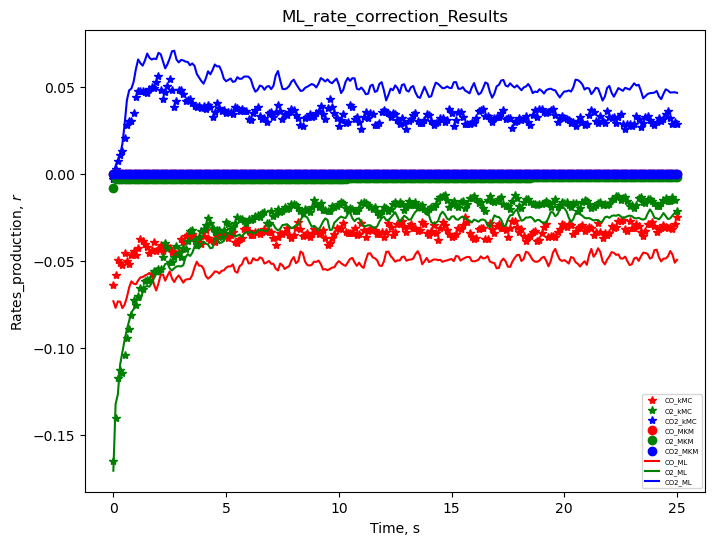

CPU times: user 310 ms, sys: 52.7 ms, total: 363 ms
Wall time: 430 ms


In [42]:
%%time
#%matplotlib notebook
plt.figure(figsize = (8, 6))
plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,0],'r*', label='CO_kMC')        
plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,1],'g*', label='O2_kMC') 
plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,2], 'b*', label='CO2_kMC') 

plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,0],'ro', label='CO_MKM')        
plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,1],'go', label='O2_MKM') 
plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,2], 'bo', label='CO2_MKM') 

plt.plot(test_data_time_interv, ML_Rates_pred[:,0],'r-', label='CO_ML')        
plt.plot(test_data_time_interv, ML_Rates_pred[:,1],'g-', label='O2_ML') 
plt.plot(test_data_time_interv, ML_Rates_pred[:,2], 'b-', label='CO2_ML') 

#plt.ylim([-0.1 ,0.1])
plt.xlabel('Time, s')
plt.ylabel("Rates_production, $r$")
plt.title('ML_rate_correction_Results')
plt.legend(fontsize=5, loc='best')
plt.show()

***
<a id="7"></a> 
## 7. Exploring and Evaluating possible ML options
<a href="#top">Back to top</a>
***

--------------------------------------------------
Algorithm: XGBoost 


Elapsed Model Training Time: 
 758.7340009212494 seconds 
 12.645566682020823 minutes

Root Mean Squared Error when using XGBoost :
 0.015259350393940527


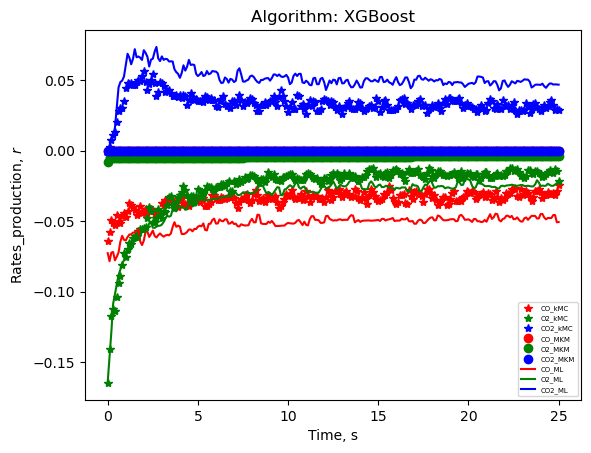

--------------------------------------------------
Algorithm: ANN 

Number of Hidden layer nodes per layer :  128
Number of Hidden layers:  4

Elapsed Model Training Time: 
 798.3743278980255 seconds 
 13.306238798300425 minutes

Root Mean Squared Error when using ANN :
 0.06703279374857071


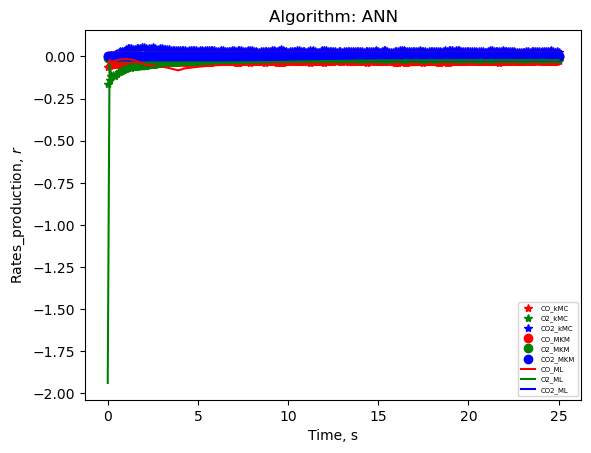

--------------------------------------------------
Algorithm: KNN 


Elapsed Model Training Time: 
 798.8009920120239 seconds 
 13.313349866867066 minutes

Root Mean Squared Error when using KNN :
 0.015459796650543143


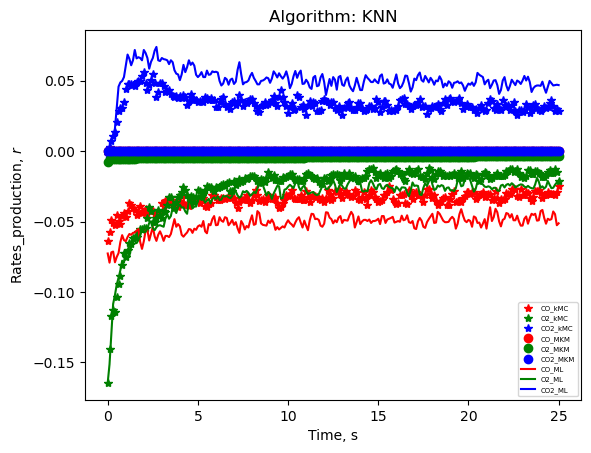

--------------------------------------------------
Algorithm: RandomForest 

Features: Index(['Init_Covg_CO*', 'Init_Covg_O*', 'Init_Covg_O2*', 'Init_Covg_*', 'Time',
       'MKM_Covg_CO*', 'MKM_Covg_O*', 'MKM_Covg_O2*', 'MKM_Covg_*',
       'MKM_iRate_CO', 'MKM_iRate_O2', 'MKM_iRate_CO2'],
      dtype='object')

Feature Importance:
 [0.02679002 0.2674524  0.         0.02046036 0.09714754 0.03283602
 0.10767654 0.         0.1367566  0.         0.12305702 0.1878235 ]

Elapsed Model Training Time: 
 942.8483459949493 seconds 
 15.714139099915823 minutes

Root Mean Squared Error when using RandomForest :
 0.015251661601720434


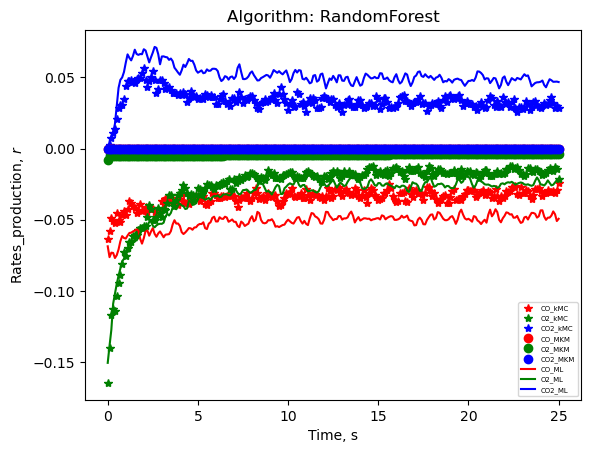

--------------------------------------------------
Algorithm: DecisionTree 

Features: Index(['Init_Covg_CO*', 'Init_Covg_O*', 'Init_Covg_O2*', 'Init_Covg_*', 'Time',
       'MKM_Covg_CO*', 'MKM_Covg_O*', 'MKM_Covg_O2*', 'MKM_Covg_*',
       'MKM_iRate_CO', 'MKM_iRate_O2', 'MKM_iRate_CO2'],
      dtype='object')

Feature Importance:
 [6.90156780e-03 1.97893199e-01 0.00000000e+00 1.70463329e-04
 1.91272340e-02 5.16520437e-02 6.44833873e-02 0.00000000e+00
 1.09854413e-02 0.00000000e+00 5.02518511e-01 1.46268152e-01]

Elapsed Model Training Time: 
 943.3590459823608 seconds 
 15.72265076637268 minutes

Root Mean Squared Error when using DecisionTree :
 0.015459796650546975


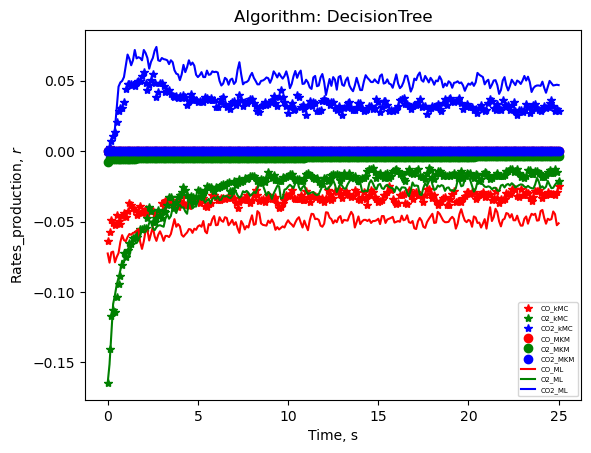

CPU times: user 44min 16s, sys: 5min 5s, total: 49min 22s
Wall time: 9min 16s


In [39]:
%%time
#%matplotlib notebook
import time
from math import sqrt
from sklearn.metrics import mean_squared_error

algs = ['XGBoost','ANN','KNN','RandomForest','DecisionTree']
rmse_vec = []
for v in np.arange(len(algs)):
    
    print("-"*50)
    print('Algorithm:',algs[v],'\n')
    
    tart_time = time.time()  
    reg = ML_model(algorithm=algs[v])
    end_time = time.time()

    elapsed_time = end_time - start_time
    print("\nElapsed Model Training Time: \n", elapsed_time, "seconds \n", elapsed_time/60, "minutes")
    
    Test_output = reg.predict(Test_input)

    Pred_corr = Test_output[:,-3:] #extracting correction factors #CO #O2 #CO2
    
    #Calculating extracted ML predicted rates
    ML_Rates_pred = np.zeros((len(test_data_time_interv),3)) #CO, O2, CO2
    for i in np.arange(np.shape(ML_Rates_pred)[0]):
        for j in np.arange(np.shape(ML_Rates_pred)[1]):
            ML_Rates_pred[i,j] = MKM_Rates_test_inp[i,j]*np.exp(Pred_corr[i,j])
    
    #Calculating the root mean squared of the test set
    rmse = sqrt(mean_squared_error(KMC_Data_EXP_rates, ML_Rates_pred))
    print('\nRoot Mean Squared Error when using',algs[v],':\n',rmse)
    rmse_vec.append(rmse)
    
    plt.figure()
    plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,0],'r*', label='CO_kMC')        
    plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,1],'g*', label='O2_kMC') 
    plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,2], 'b*', label='CO2_kMC') 

    plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,0],'ro', label='CO_MKM')        
    plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,1],'go', label='O2_MKM') 
    plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,2], 'bo', label='CO2_MKM') 

    plt.plot(test_data_time_interv, ML_Rates_pred[:,0],'r-', label='CO_ML')        
    plt.plot(test_data_time_interv, ML_Rates_pred[:,1],'g-', label='O2_ML') 
    plt.plot(test_data_time_interv, ML_Rates_pred[:,2], 'b-', label='CO2_ML') 

    plt.xlabel('Time, s')
    plt.ylabel("Rates_production, $r$")
    plt.title('Algorithm: {}'.format(algs[v]))
    plt.legend(fontsize=5, loc='best')

    plt.show()

In [40]:
print("The ML model giving the smallest rmse of", rmse_vec[np.argmin(rmse_vec)],"is : \n",algs[np.argmin(rmse_vec)]) 

The ML model giving the smallest rmse of 0.015251661601720434 is : 
 RandomForest
